# Adquisición de datos automatizada
![](logo_fifa.png)

En este notebook vamos a presentar la adquisición automática de datos, a partir de un osciloscopio Tektronix TDS2000. La idea es que saquemos información relevante de estos datos, veremos que tenemos a mano

In [1]:
import visa
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Para la adquisición hicimos una clase que abstrae el uso del osciloscopio TDS2000

In [2]:
class Osciloscopio(object):
    '''Clase para el manejo osciloscopio TDS2000 usando PyVISA de interfaz'''
    def __init__(self, resource):
        #Defino el recurso
        self._osci = visa.ResourceManager("@py").open_resource(resource)
        self._osci.query("*IDN?")

        #Configuración de curva
        self._osci.write('DAT:ENC RPB') # Modo de transmision: Binario positivo. 
        self._osci.write('DAT:WID 1') #1 byte de dato. Con RPB 127 es la mitad de la pantalla
        self._osci.write("DAT:STAR 1") #La curva mandada inicia en el primer dato
        self._osci.write("DAT:STOP 2500") #La curva mandada finaliza en el último dato


        #Adquisición por sampleo
        self._osci.write("ACQ:MOD SAMP")

        #Seteo de canal
        self.setCanal(canal = 1, escala = 20e-3)
        self.setCanal(canal = 2, escala = 20e-3)
        self.setTiempo(escala = 1e-3, cero = 0)

        #Bloquea el control del osciloscopio
        self._osci.write("LOC")

    def __del__(self):
        self._osci.write("UNLOC") #Desbloquea el control del osciloscopio
        self._osci.close()

    def setCanal(self, canal, escala, cero = 0):
        #if coup != "DC" or coup != "AC" or coup != "GND":
        #coup = "DC"
        #self._osci.write("CH{0}:COUP ".format(canal) + coup) #Acoplamiento DC
        #self._osci.write("CH{0}:PROB 
        print
        self._osci.write("CH{0}:SCA {1}".format(canal,escala))
        self._osci.write("CH{0}:POS {1}".format(canal,cero))

    def getCanal(self,canal):
        return self._osci.query("CH{0}?".format(canal))

    def setTiempo(self, escala, cero = 0):
        self._osci.write("HOR:SCA {0}".format(escala))
        self._osci.write("HOR:POS {0}".format(cero))	
        
    def getTiempo(self):
        return self._osci.query("HOR?")
    
    def getVentana(self,canal):
        self._osci.write("SEL:CH{0} ON".format(canal)) #Hace aparecer el canal en pantalla. Por si no está habilitado
        self._osci.write("DAT:SOU CH{0}".format(canal)) #Selecciona el canal
        #xze primer punto de la waveform
        #xin intervalo de sampleo
        #ymu factor de escala vertical
        #yoff offset vertical
        xze, xin, yze, ymu, yoff = self._osci.query_ascii_values('WFMPRE:XZE?;XIN?;YZE?;YMU?;YOFF?;', 
                                                                 separator=';') 
        data = (self._osci.query_binary_values('CURV?', datatype='B', 
                                               container=np.array) - yoff) * ymu + yze        
        tiempo = xze + np.arange(len(data)) * xin
        return tiempo, data


In [ ]:
rm = visa.ResourceManager('@py')
rm.list_resources()

In [ ]:
osci = Osciloscopio('USB0::0x0699::0x0363::C108013::INSTR')
osci.setCanal(1, 2)

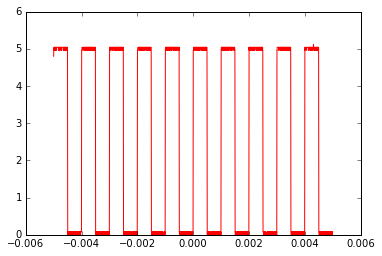

In [19]:
t,V = osci.getVentana(1)
plt.plot(t,V,"r-")